<h1>分類問題 - 学習</h1>
<h4>CIFAR10データセットに含まれている画像データを「飛行機」、「猫」、「カエル」などのように種族ごとに分類する</h4>
<h4>CIFAR10の画像サイズは3*32*32、 32*32ピクセルの3チャンネルカラー画像である。</h4>
<h3>【手順】</h3>
<h5>1.CIFAR10トレーニングおよびテストデータセットの読み込みと正規化</h5>
<h5>2.畳み込みニューラルネットワークの定義</h5>
<h5>3.損失関数の定義</h5>
<h5>4.トレーニングデータでネットワークをトレーニングする</h5>
<h5>5.テストデータでネットワークをテストする</h5>

In [1]:
## 1-1.CIFAR10のロードおよび正規化
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
# 訓練データのロード
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
# テストデータのロード
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


 deer truck  frog  frog


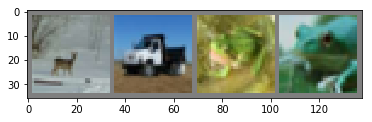

In [2]:
## 1-2.訓練画像の参照
import matplotlib.pyplot as plt
import numpy as np
#jupyter上でmatplotlibによる画像表示を許可する
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5 #unnormalize <- ?
    npimg = img.numpy() #行列化
    plt.imshow(np.transpose(npimg, (1,2,0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<h4>input -> Conv1 -> MaxPool -> Conv2 -> MaxPool</h4>
<h4>reshape -> 線形変換 -> 活性化関数 -> 線形変換 -> 活性化関数 -> 線形変換</h4>
<h5>torch.nn.Conv2d()</h5>
<h5>in_channels : 入力画像のチャンネル数</h5>
<h5>out_channels : 畳み込みによって生成されたチャンネル数</h5>
<h5>kernel_size : 畳み込みのカーネル（フィルター）サイズ</h5>
<h5>[ stride ]</h5>
<h5>[ padding ]</h5>
<img src="CNN.png">
<h6>初期入力は32*32*3を想定</h6>

In [3]:
## 畳み込みニューラルネットワークの定義
## 1チャンネル画像ではなく3チャンネル画像をとるように修正
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        # 線形変換
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # 畳み込み層 -> プーリング層
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        # 全結合層
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [4]:
## Loss関数と最適化関数を定義する
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
## ネットワークのトレーニング
for epoch in range(2):
    running_loss = 0.0
    for i,data in enumerate(trainloader, 0):
        #入力データの取得
        inputs, labels = data
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels) #lossの取得
        loss.backward()
        optimizer.step() #最適化
        
        running_loss += loss.item()
        if i%2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.279
[1,  4000] loss: 1.904
[1,  6000] loss: 1.702
[1,  8000] loss: 1.602
[1, 10000] loss: 1.548
[1, 12000] loss: 1.485
[2,  2000] loss: 1.416
[2,  4000] loss: 1.377
[2,  6000] loss: 1.367
[2,  8000] loss: 1.319
[2, 10000] loss: 1.308
[2, 12000] loss: 1.266
Finished Training


GroundTruth: truck  ship horse  ship


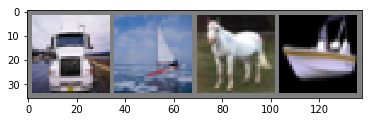

In [6]:
## ネットワークのテスト
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [7]:
outputs = net(images)

In [8]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    car plane horse  ship


In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 teset images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 teset images: 55 %


In [10]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[1]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 55 %
Accuracy of  bird : 52 %
Accuracy of   cat : 50 %
Accuracy of  deer : 55 %
Accuracy of   dog : 56 %
Accuracy of  frog : 58 %
Accuracy of horse : 57 %
Accuracy of  ship : 56 %
Accuracy of truck : 57 %
